# Coordinate Descent method

In this analysis we will compare the different possible techniques used for coordinate gradient descent, that consists in updating only one dimension of the feature array x for each step.

The objective function to be minimized is still:

<br /><br /> $$f(x) = \frac{1}{2}\|Ax - b\|^2$$<br />

### Load libraries

In [101]:
# Base libraries
import numpy as np
import pandas as pd

# Plot libraries
import matplotlib.pyplot as plt

# Math libraries
import math

### Load dataset

In [102]:
# Load the dataset
dataset = pd.read_csv("Data/student_habits_performance_clean.csv", encoding='utf-8')
target_col = 'exam score [scale 1-10]'
print(dataset.columns.tolist())


['student_id', 'age [years]', 'gender', 'study hours per day', 'social media hours', 'Netflix hours', 'part_time_job', 'attendance percentage', 'sleep hours', 'diet_quality', 'exercise frequency [times/week]', 'parental_education_level', 'internet_quality', 'mental health rating [scale 1-10]', 'extracurricular_participation', 'exam score [scale 1-10]']


### Data Standardization and Design Matrix Construction for Regression

In [103]:
# Standardize data to mean 0 and std dev 1.
def standardize(x):
    return (x - np.mean(x)) / np.std(x)

# Get regression data in matrix form.
def build_model_data(x, y):
    b = y
    num_samples = len(b)
    A = np.c_[np.ones(num_samples), x]  # Add intercept column
    return A, b

# Select all numeric columns except 'student_id' and target
numeric_cols = dataset.select_dtypes(include=[np.number]).columns.tolist()
if 'student_id' in numeric_cols:
    numeric_cols.remove('student_id')
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

# Extract features and target
features = dataset[numeric_cols].values
target = dataset['exam score [scale 1-10]'].values

# Standardize all numeric features
features_standardized = np.apply_along_axis(standardize, 0, features)
target_standardized = standardize(target)

# Build the model data matrix with intercept
A, b = build_model_data(features_standardized, target_standardized)


# Define f(x) and grad(f(x)) functions for future use
def calculate_objective(Axmb):
    """Calculate 1/2*||Ax - b||^2 for the vector Axmb = Ax - b"""
    obj = 0.5 * (Axmb**2).sum()
    return obj

# We only compute gradient for one coordinate, calculating the whole gradient for each step anyway would make coordinate descent useless
def compute_coordinate_gradient(A, x, b,i):
    """Compute the gradient for coordinate i and objective function."""
    Axmb = A.dot(x) - b
    grad_i = A[:,i].T.dot(Axmb)
    return grad_i, Axmb


# Calculate the smoothness constant for f
def calculate_L(A):
    return np.linalg.norm(A.T @ A, ord=2)
    return L


## Random coordinate descent

In this variation of coordinate descent, the direction picked at any given step is completely random.

In [104]:
def rand_coordinate_descent(A, initial_x, b, max_iters, gamma):
    """Random coordinate descent algorithm"""
    xs = [initial_x]
    objectives = []
    x = initial_x
    n=len(x)

    for n_iter in range(max_iters):
        # Choose a random coordinate from x
        i = np.random.randint(0, n)
        # Use that coordinate to compute step
        grad, Axmb = compute_coordinate_gradient(A, x, b,i)
        obj = calculate_objective(Axmb)
        objectives.append(obj)

        x[i]=x[i]-gamma*grad
        
        xs.append(x.copy())
        
        
        print("Random coordinate Descent({bi}/{ti}): objective={l:.5f}, x={w}".format(
        bi=n_iter, ti=max_iters, l=obj,
        w=np.array2string(x, precision=5, separator=", ",
                       formatter={'float_kind':lambda x: f"{x:.5f}"})))
        
    return objectives, xs

For testing we will use step size $\gamma_t = \frac{1}{L}$, with L being the Lipschitz constant. We do this as we assume coordinate-wise smoothness and coordinate-wise Lipschitz gradient.

In [105]:
# Define the parameters of the algorithm.
max_iters = 100

L = calculate_L(A)
gamma_smooth = 1/L
print(L)

# Initialization
x_initial = np.zeros(A.shape[1])

# Start gradient descent.
RCD_objectives_smooth, RCD_xs_smooth = rand_coordinate_descent(A, x_initial, b, max_iters, gamma_smooth)

990.2836288154625
Random coordinate Descent(0/100): objective=454.50000, x=[0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,
 0.29185]
Random coordinate Descent(1/100): objective=408.86472, x=[0.00000, 0.00000, 0.00000, -0.15747, 0.00000, 0.00000, 0.00000, 0.00000,
 0.29185]
Random coordinate Descent(2/100): objective=395.57906, x=[0.00000, 0.00000, 0.00000, -0.15747, 0.00000, 0.00000, 0.00000, 0.14509,
 0.29185]
Random coordinate Descent(3/100): objective=384.30090, x=[0.00000, -0.00050, 0.00000, -0.15747, 0.00000, 0.00000, 0.00000, 0.14509,
 0.29185]
Random coordinate Descent(4/100): objective=384.30077, x=[0.00000, -0.00054, 0.00000, -0.15747, 0.00000, 0.00000, 0.00000, 0.14509,
 0.29185]
Random coordinate Descent(5/100): objective=384.30077, x=[0.00000, -0.00054, 0.00000, -0.15747, 0.00000, 0.00000, 0.00000, 0.14509,
 0.31592]
Random coordinate Descent(6/100): objective=383.99038, x=[0.00000, -0.00054, 0.00000, -0.16720, 0.00000, 0.00000, 0.00000, 0.14509,
 0

NOTE: we cannot implement convergence checking with this algorithm as the randomly chosen coordinate at a certain iteration might have a resulting gradient of zero, causing the step to be null and the execution to stop before the actual optimum is reached.

## Importance sampling

In this variation, the choice of which coordinate will be used for each step is still random, but the probability distribution is based on the smoothness constant associated with every coordinate:

$$
p_i = \frac{L_i}{\sum_{j=1}^{n} L_j} = \frac{\|A_i\|^2}{\sum_{j=1}^{n} \|A_j\|^2}
$$
 

In [106]:
def importance_sampl_coordinate_descent(A, initial_x, b, max_iters, gamma):
    """Importance sampling coordinate descent algorithm"""
    xs = [initial_x]
    objectives = []
    x = initial_x.copy()
    n = len(x)

    # Compute importance sampling probabilities: p_i ∝ ||A_i||^2
    col_norms_squared = np.sum(A ** 2, axis=0)
    prob_dist = col_norms_squared / np.sum(col_norms_squared)

    for n_iter in range(max_iters):
        # Importance sampling: choose i ~ prob_dist
        i = np.random.choice(n, p=prob_dist)

        # Compute gradient and objective
        grad, Axmb = compute_coordinate_gradient(A, x, b, i)
        obj = calculate_objective(Axmb)
        objectives.append(obj)

        # Gradient update
        x[i] = x[i] - gamma * grad
        xs.append(x.copy())

        print("Importance Sampling Descent({bi}/{ti}): objective={l:.5f}, x={w}".format(
            bi=n_iter, ti=max_iters, l=obj,
            w=np.array2string(x, precision=5, separator=", ",
                              formatter={'float_kind': lambda x: f"{x:.5f}"})))


    return objectives, xs


In [107]:
# Define the parameters of the algorithm.
max_iters = 100

# Initialization
x_initial = np.zeros(A.shape[1])

# Start gradient descent.
IS_objectives_smooth, IS_xs_smooth = importance_sampl_coordinate_descent(A, x_initial, b, max_iters, gamma_smooth)

Importance Sampling Descent(0/100): objective=454.50000, x=[0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.14815,
 0.00000]
Importance Sampling Descent(1/100): objective=442.74052, x=[0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.16031,
 0.00000]
Importance Sampling Descent(2/100): objective=442.66129, x=[0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.10784, 0.16031,
 0.00000]
Importance Sampling Descent(3/100): objective=436.43048, x=[0.00000, 0.00000, 0.76163, 0.00000, 0.00000, 0.00000, 0.10784, 0.16031,
 0.00000]
Importance Sampling Descent(4/100): objective=125.62947, x=[0.00000, 0.00000, 0.76163, 0.00000, -0.14048, 0.00000, 0.10784, 0.16031,
 0.00000]
Importance Sampling Descent(5/100): objective=115.05623, x=[0.00000, 0.00000, 0.76163, 0.00000, -0.14048, 0.00000, 0.13284, 0.16031,
 0.00000]
Importance Sampling Descent(6/100): objective=114.72125, x=[0.00000, 0.00000, 0.76163, 0.00000, -0.15162, 0.00000, 0.13284, 0.16031,
 0.00000]
Imp

## Steepest coordinate descent

This method, unlike the previous two, is deterministic: the direction chosen for each iteration is the one with the larger absolute value of the gradient.

In [108]:
def steepest_coordinate_descent(A, initial_x, b, max_iters, gamma):
    """Steepest coordinate descent algorithm"""
    xs = [initial_x]
    objectives = []
    x = initial_x.copy()
    n = len(x)

    for n_iter in range(max_iters):
        # Calcola tutti i gradienti parziali (uno per ogni coordinata)
        gradients = np.zeros(n)
        for i in range(n):
            grad_i, _ = compute_coordinate_gradient(A, x, b, i)
            gradients[i] = grad_i

        # Seleziona la coordinata con il gradiente più "ripido" (in valore assoluto)
        i = np.argmax(np.abs(gradients))

        # Calcola gradiente e obiettivo solo per la coordinata scelta
        grad, Axmb = compute_coordinate_gradient(A, x, b, i)
        obj = calculate_objective(Axmb)
        objectives.append(obj)

        # Aggiorna la variabile nella direzione più ripida
        x[i] = x[i] - gamma * grad
        xs.append(x.copy())

        print("Steepest Descent({bi}/{ti}): objective={l:.5f}, x={w}".format(
            bi=n_iter, ti=max_iters, l=obj,
            w=np.array2string(x, precision=5, separator=", ",
                              formatter={'float_kind': lambda x: f"{x:.5f}"})))
        

    return objectives, xs

In [109]:
# Define the parameters of the algorithm.
max_iters = 100

# Initialization
x_initial = np.zeros(A.shape[1])

# Start gradient descent.
SCD_objectives_smooth, SCD_xs_smooth = steepest_coordinate_descent(A, x_initial, b, max_iters, gamma_smooth)

Steepest Descent(0/100): objective=454.50000, x=[0.00000, 0.00000, 0.75540, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,
 0.00000]
Steepest Descent(1/100): objective=148.76542, x=[0.00000, 0.00000, 0.75540, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,
 0.30287]
Steepest Descent(2/100): objective=99.61796, x=[0.00000, 0.00000, 0.75540, 0.00000, 0.00000, 0.00000, 0.00000, 0.16570,
 0.30287]
Steepest Descent(3/100): objective=84.90751, x=[0.00000, 0.00000, 0.75540, -0.15893, 0.00000, 0.00000, 0.00000, 0.16570,
 0.30287]
Steepest Descent(4/100): objective=71.37510, x=[0.00000, 0.00000, 0.75540, -0.15893, -0.13587, 0.00000, 0.00000, 0.16570,
 0.30287]
Steepest Descent(5/100): objective=61.48346, x=[0.00000, 0.00000, 0.75540, -0.15893, -0.13587, 0.00000, 0.13065, 0.16570,
 0.30287]
Steepest Descent(6/100): objective=52.33859, x=[0.00000, 0.00000, 0.75540, -0.15893, -0.13587, 0.07949, 0.13065, 0.16570,
 0.30287]
Steepest Descent(7/100): objective=48.95313, x=[0.00000, 0.00000, 0.82588, -0.158

## Comparing the three methods

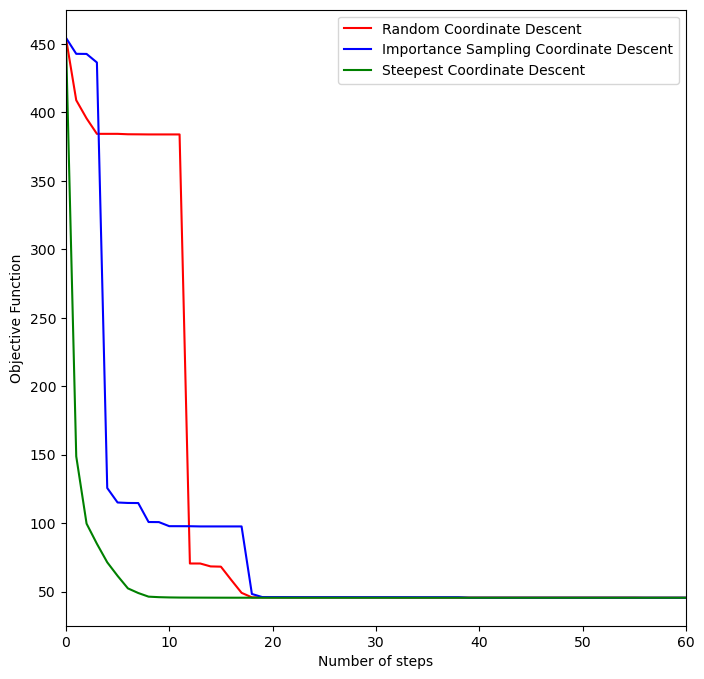

In [110]:
plt.figure(figsize=(8, 8))
plt.xlabel('Number of steps')
plt.ylabel('Objective Function')

plt.plot(range(len(RCD_objectives_smooth)), RCD_objectives_smooth,'red', label='Random Coordinate Descent')
plt.plot(range(len(IS_objectives_smooth)), IS_objectives_smooth,'blue', label='Importance Sampling Coordinate Descent')
plt.plot(range(len(SCD_objectives_smooth)), SCD_objectives_smooth,'green', label='Steepest Coordinate Descent')

plt.xlim(0,60)
plt.legend(loc='upper right')
plt.show()


From the graph we can conclude that all three algorithms converge to the optimal solution in less than 40 iterations; a lot less than with Stochastic Gradient descent.

- Steepest Coordinate descent is by far the fastest method, as it deterministically chooses for each iteration to move in the most important direction (the one with the largest gradient);

- Importance Sampling is slower, as computed importance for any coordinate at each step dictates only the probability of selection of such coordinate: the chosen direction is often the most important one, but not always;

- Random Coordinate descent, utilizing completely uniform random choice on the coordinate to use at each step, has the most variance in its results: on one run it may reach the optimum faster than IS, on others it reaches it much more slowly.
